In [1]:
import transformers 
from transformers import AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import math
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_names = ['not_sarcastic', 'sarcastic']
print(device)

cuda


In [2]:
#数据集

df_En = pd.read_csv("/home/yang/NLP_train/classificationWithBERT/train.En.csv")

df_Ar = pd.read_csv("/home/yang/NLP_train/classificationWithBERT/train.Ar.csv")

In [3]:
df_Ar = df_Ar.drop(['id','rephrase','dialect'],axis=1)
df_Ar

,tweet,sarcastic
0,احلى اشي بالدنيا تكون بعلاقة و تحس انك وحيد,1
1,ويندوز احسن نظام تشغيل بالدنيا,1
2,الامور منيحة و النفسية اعلى من هيك فش,1
3,شركة فيسبوك اكثر شركة بهتموا بالخصوصية,1
4,الجهاز هون كثير ممتاز و ما بعلق ابدا، صرلي ساع...,1
...,...,...
2597,كيري: ندرك أن الوصول لحل مستقر ودائم يتطلب تنا...,0
2598,حقك كبير 😳😳قم عدل المنكر .. ولدك في خطر !! كر...,0
2599,ارفض البذاءات التى يبثها الشيخ محمود شعبان ضد ...,0
2600,احمد شفيق هو الوحيد القادر علي تحريك الركود ال...,0


In [4]:
df_Ar = df_Ar[:1000]

train total 1000 sarcastic 500 non sarcastic 500


/home/yang/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


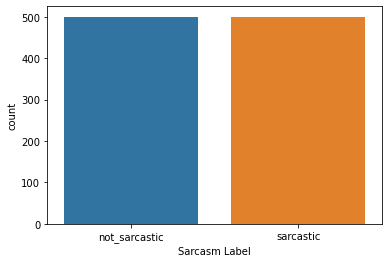

In [5]:
ax = sns.countplot(df_Ar.sarcastic)
plt.xlabel('Sarcasm Label')
ax.set_xticklabels(class_names)
As_train = 0
Ans_train = 0
for i in df_Ar.sarcastic:
    if i == 1:
        As_train+=1
    else:
        Ans_train+=1
l_count = len(df_Ar.sarcastic)
print("train total", l_count, "sarcastic", As_train, "non sarcastic", Ans_train)

In [6]:
df_En = df_En[:1734]

train total 1734 sarcastic 867 non sarcastic 867


/home/yang/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


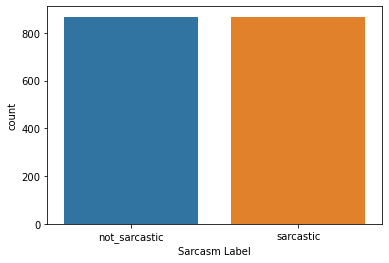

In [7]:
ax = sns.countplot(df_En.sarcastic)
plt.xlabel('Sarcasm Label')
ax.set_xticklabels(class_names)
s_train = 0
ns_train = 0
for i in df_En.sarcastic:
    if i == 1:
        s_train+=1
    else:
        ns_train+=1
l_count = len(df_En.sarcastic)
print("train total", l_count, "sarcastic", s_train, "non sarcastic", ns_train)

In [8]:
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'
bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, normalization=True)

In [10]:
MAX_LEN = 100

In [11]:
class TweetDataset(Dataset):

    def __init__(self, tweets, targets, tokenizer, max_len):
        self.tweets = tweets
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.tweets)
    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            tweet, add_special_tokens=True, max_length=self.max_len, 
            return_token_type_ids=False, pad_to_max_length=True,
            return_attention_mask=True, return_tensors='pt',
        )
        return {
            'tweet_text':tweet,
            'input_ids':encoding['input_ids'].flatten(),
            'attention_mask':encoding['attention_mask'].flatten(),
            'targets':torch.tensor(target, dtype=torch.long)
        }

In [12]:
df_En

,Unnamed: 0,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,0,The only thing I got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0.0,1.0,0.0,0.0,0.0,0.0
1,1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0
2,2,Remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0.0,1.0,0.0,0.0,0.0,0.0
3,3,Today my pop-pop told me I was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1.0,0.0,0.0,0.0,0.0,0.0
4,4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I would say Ted Cruz is an asshole and doesn’t...,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1729,1729,i just overheard this bunch of children behind...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1730,1730,started telling my dutch friends about how i'v...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1731,1731,took my dog to the vet today because i thought...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1732,1732,have to somehow become fluent in Spanish in th...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df_Ar

,tweet,sarcastic
0,احلى اشي بالدنيا تكون بعلاقة و تحس انك وحيد,1
1,ويندوز احسن نظام تشغيل بالدنيا,1
2,الامور منيحة و النفسية اعلى من هيك فش,1
3,شركة فيسبوك اكثر شركة بهتموا بالخصوصية,1
4,الجهاز هون كثير ممتاز و ما بعلق ابدا، صرلي ساع...,1
...,...,...
995,قالها جستن بيبر ؛ انا مو ولهان انا انا دنيا م...,0
996,مواليد برج الأسد تعجبك صداقتهم كثيراً,0
997,ماذا لو المدارس مختلطه ماراح اغيب ولا يوم,0
998,3 ماعنديش مانع انا بتكلم عن الفجر في الخصومة,0


In [14]:
df_total = pd.concat((df_En, df_Ar), join='outer')

df_total = df_total.dropna(subset=['tweet'])
df_total =df_total.dropna(axis=1,how='any')
df_total =df_total.reset_index(drop=True)
df_total


,tweet,sarcastic
0,The only thing I got from college is a caffein...,1
1,I love it when professors draw a big question ...,1
2,Remember the hundred emails from companies whe...,1
3,Today my pop-pop told me I was not “forced” to...,1
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1
...,...,...
2728,قالها جستن بيبر ؛ انا مو ولهان انا انا دنيا م...,0
2729,مواليد برج الأسد تعجبك صداقتهم كثيراً,0
2730,ماذا لو المدارس مختلطه ماراح اغيب ولا يوم,0
2731,3 ماعنديش مانع انا بتكلم عن الفجر في الخصومة,0


In [15]:
import re
def clearTextFunc(text):
    clear_text= " ".join(text.split())
    clear_text=re.sub(r'http://[a-zA-Z0-9.?/&=:]*'," ", clear_text) #去除URL
    clear_text=re.sub(r'https://[a-zA-Z0-9.?/&=:]*'," ", clear_text) #去除URL
    clear_text=re.sub(r'@[a-zA-Z0-9.?/&=:]*'," ", clear_text)#去除@
    clear_text=re.sub(r'/s'," ",clear_text)
    clear_text=re.sub(r'/j'," ",clear_text)

    return clear_text

In [16]:
df_total['tweet']=df_total['tweet'].apply(clearTextFunc)
df_total

,tweet,sarcastic
0,The only thing I got from college is a caffein...,1
1,I love it when professors draw a big question ...,1
2,Remember the hundred emails from companies whe...,1
3,Today my pop-pop told me I was not “forced” to...,1
4,"I did too, and I also reported Cancun Cr...",1
...,...,...
2728,قالها جستن بيبر ؛ انا مو ولهان انا انا دنيا من...,0
2729,مواليد برج الأسد تعجبك صداقتهم كثيراً,0
2730,ماذا لو المدارس مختلطه ماراح اغيب ولا يوم,0
2731,3 ماعنديش مانع انا بتكلم عن الفجر في الخصومة,0


train total 2733 sarcastic 1367 non sarcastic 1366


/home/yang/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


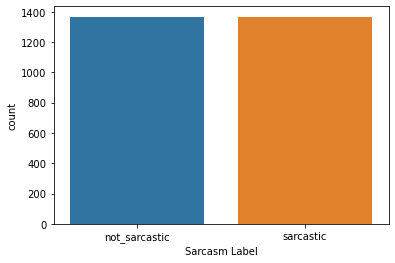

In [17]:
ax = sns.countplot(df_total.sarcastic)
plt.xlabel('Sarcasm Label')
ax.set_xticklabels(class_names)
ts_train = 0
tns_train = 0
for i in df_total.sarcastic:
    if i == 1:
        ts_train+=1
    else:
        tns_train+=1
l_count = len(df_total.sarcastic)
print("train total", l_count, "sarcastic", ts_train, "non sarcastic", tns_train)

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=RANDOM_SEED)
for train_index, text_index in split.split(df_total, df_total['sarcastic']):
    df_train = df_total.loc[train_index]
    df_val = df_total.loc[text_index]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
    

In [19]:
df_train

,tweet,sarcastic
0,_Warner Not sure if this has been answe...,0
1,This second jab has made me feel off the box t...,0
2,My dad is bringing me home Spider-Man Vans fro...,0
3,جمال سلطان فضح الانقلاب واعاد الحق لمرسي بعد ا...,0
4,#Snowden Sad to see intelligent Americans fall...,0
...,...,...
1908,الإرهاب نهايته 'مزبلة التاريخ',0
1909,I’m at a weird point in my life where I’m on e...,0
1910,روح يا راجل شوفلك حته ناشفة اقعد فيها,1
1911,سبحان العاطى الوهاب من بعد الشبشب والاوبئاب,1


In [20]:
df_val

,tweet,sarcastic
0,i want tech to be banned for use in work relat...,0
1,happy birthday gorgeous! have an amazing day i...,0
2,Thank you to for organising pizza and ice cr...,1
3,احلى أغنية تيتر في رمضان اغنية شيرين - مشاعر م...,0
4,بيشتغل تلات ساعات ويرجع يقول تعبان مش قادر,1
...,...,...
815,وحيات عينيك ،،،، اخذ صوت اخذ وجه حسن وطرب اصيي...,0
816,The most 2020 quote of the year: Me: we should...,1
817,ماتاكلش دماغي أنا مش ناقص,1
818,البنت لما يحكولها ليه حطه مكياج كتير تقول ده ج...,1


In [21]:
df_train.shape

(1913, 2)

In [22]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TweetDataset(
        tweets=df.tweet.to_numpy(),
        targets=df.sarcastic.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

In [23]:
BATCH_SIZE=16
train_data_loader = create_data_loader(df_train,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

In [24]:
data = next(iter(train_data_loader))
data.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, ple

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])

In [25]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 100])
torch.Size([16, 100])
torch.Size([16])


In [26]:
class SarcasmClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SarcasmClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.embed_size = self.bert.config.hidden_size
        self.label_num = n_classes
        self.fc_dropout = 0.2
        self.hidden_num = 1
        self.hidden_size = 256
        self.hidden_dropout = 0.5
        self.bidirectional = True
        self.pad_size=32
        

        
        self.lstm = nn.LSTM(
            input_size=self.embed_size,
            hidden_size=self.hidden_size,
            num_layers=self.hidden_num,
            bidirectional=True,
            #dropout=self.hidden_dropout,
            batch_first=True
        )
        self.maxpool = nn.MaxPool1d(self.pad_size)

        self.dropout=nn.Dropout(self.hidden_dropout)
        self.fc_dropout = nn.Dropout(self.fc_dropout)
        self.linear1 = nn.Linear(self.hidden_size *2, self.hidden_size//2)
        self.linear2 = nn.Linear(self.hidden_size//2, self.label_num)
        

    def forward(self, input_ids, attention_mask):
        #sequence_output size: (batch_size, sequence_length, 768)
        sequence_output, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        
        lstm_out,(hidden_last,cn_last) = self.lstm(sequence_output)
        #hidden = torch.cat((lstm_out[:,-1,:256], lstm_out[:,0,256:]), dim=-1)
        #hidden = hidden.view(-1,256*2)
        
        if self.bidirectional:
            hidden_last_L= hidden_last[-2]
            hidden_last_R = hidden_last[-1]
            hidden = torch.cat([hidden_last_L, hidden_last_R],dim=-1)
        else:
            hidden=hidden_last[-1]
        out=self.dropout(hidden)
       # out = hidden.permute(0, 2, 1)
       # out = self.maxpool(out).squeeze()
        out = F.relu(self.linear1(hidden))
        out = self.fc_dropout(out)
        output = self.linear2(out)

        return output
        

        

In [27]:
class SarcasmClassifier_Ori(nn.Module):
    def __init__(self, n_classes):
        super(SarcasmClassifier_Ori, self).__init__()
        self.bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask, return_dict=False
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [28]:
model = SarcasmClassifier(len(class_names))
#model = SarcasmClassifier_Ori(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
for name, parameters in model.named_parameters():
    print(name,':',parameters.size())

bert.embeddings.word_embeddings.weight : torch.Size([119547, 768])
bert.embeddings.position_embeddings.weight : torch.Size([512, 768])
bert.embeddings.token_type_embeddings.weight : torch.Size([2, 768])
bert.embeddings.LayerNorm.weight : torch.Size([768])
bert.embeddings.LayerNorm.bias : torch.Size([768])
bert.encoder.layer.0.attention.self.query.weight : torch.Size([768, 768])
bert.encoder.layer.0.attention.self.query.bias : torch.Size([768])
bert.encoder.layer.0.attention.self.key.weight : torch.Size([768, 768])
bert.encoder.layer.0.attention.self.key.bias : torch.Size([768])
bert.encoder.layer.0.attention.self.value.weight : torch.Size([768, 768])
bert.encoder.layer.0.attention.self.value.bias : torch.Size([768])
bert.encoder.layer.0.attention.output.dense.weight : torch.Size([768, 768])
bert.encoder.layer.0.attention.output.dense.bias : torch.Size([768])
bert.encoder.layer.0.attention.output.LayerNorm.weight : torch.Size([768])
bert.encoder.layer.0.attention.output.LayerNorm.bias :

In [30]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)


In [31]:
print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 100])
torch.Size([16, 100])


In [32]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=4e-6, correct_bias=False)
total_steps = len(train_data_loader)*EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/home/yang/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [33]:
def train_epoch(
    model, data_loader, loss_fn, optimizer, device, scheduler, n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)

        outputs = model(input_ids=input_ids,attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss=loss_fn(outputs, targets)
        correct_predictions +=torch.sum(preds==targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(),max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
   
    return correct_predictions.double()/n_examples, np.mean(losses)
    

In [34]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses=[]
    correct_predictions=0
    with torch.no_grad():
        for d in data_loader:
            input_ids=d['input_ids'].to(device)
            attention_mask=d['attention_mask'].to(device)
            targets = d['targets'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double()/n_examples, np.mean(losses)

In [35]:
from collections import defaultdict



history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    print('-'*10)
    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
    print(f'Val loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc>best_accuracy:
        best_accuracy = val_acc
 

Epoch 1/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.6522910053531329 accuracy 0.5896497647673811


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the 

Val loss 0.609310718683096 accuracy 0.6195121951219512

Epoch 2/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, ple

Train loss 0.5740719070037206 accuracy 0.683742812336644


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the 

Val loss 0.6184410876952685 accuracy 0.6365853658536585

Epoch 3/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, ple

Train loss 0.4927321357031663 accuracy 0.7600627286983794


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the 

Val loss 0.6590351685881615 accuracy 0.6463414634146342

Epoch 4/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, ple

Train loss 0.42162517867982385 accuracy 0.8254051228437009


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, ple

Val loss 0.69821120512027 accuracy 0.65

Epoch 5/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.3537476028005282 accuracy 0.8625196027182436


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the 

Val loss 0.7489814253953787 accuracy 0.6475609756097561

Epoch 6/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, ple

Train loss 0.2957061135520538 accuracy 0.8954521693674856


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the 

Val loss 0.8021491416371785 accuracy 0.6475609756097561

Epoch 7/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the 

Train loss 0.26329071695605916 accuracy 0.9121798222686879


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, ple

Val loss 0.8292389781429217 accuracy 0.65

Epoch 8/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, ple

Train loss 0.23890416255841654 accuracy 0.9221118661787767


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the 

Val loss 0.86642907674496 accuracy 0.6524390243902439

Epoch 9/10
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, ple

KeyboardInterrupt: 

# Test

In [ ]:
df_En_test = pd.read_csv("/home/yang/NLP_train/classificationWithBERT/TaskA_Test.csv")
df_test = df_En_test.dropna(subset=['tweet','sarcastic'])
df_test =df_test.dropna(axis=1,how='any')
df_test =df_test.reset_index(drop=True)
df_test['tweet']=df_test['tweet'].apply(clearTextFunc)
df_test

,tweet,sarcastic
0,"Size on the the Toulouse team, That pack is mo...",0
1,Pinball!,0
2,So the Scottish Government want people to get ...,1
3,villainous pro tip : change the device name on...,0
4,I would date any of these men :pleading_face:,0
...,...,...
1395,I’ve just seen this and felt it deserved a Ret...,0
1396,Omg how an earth is that a pen !! :clown_face:,0
1397,Bringing Kanye and drake to a tl near you,0
1398,"I love it when women are referred to as ""girl ...",1


In [44]:
df_HL_test = pd.read_csv("/home/yang/NLP_train/classificationWithBERT/Sarcasm_Headlines_Dataset_v2.csv")
df_HL_test = df_HL_test.drop('article_link',axis=1)
df_HL_test = df_HL_test.rename(columns={'is_sarcastic':'sarcastic', 'headline':'tweet'})

df_HL_test['tweet']=df_HL_test['tweet'].apply(clearTextFunc)
df_test=df_HL_test


In [ ]:
test_data_loader=create_data_loader(df_test, tokenizer,MAX_LEN,BATCH_SIZE)

In [ ]:
test_acc,_ = eval_model(
    model, test_data_loader, loss_fn, device, len(df_test)
)
test_acc.item()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the 

0.5801740102728956

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()
    tweet_texts=[]
    predictions=[]
    prediction_probs=[]
    real_values=[]
    with torch.no_grad():
        for d in data_loader:
            texts=d['tweet_text']
            input_ids=d['input_ids'].to(device)
            attention_mask=d['attention_mask'].to(device)
            targets=d['targets'].to(device)

            outputs=model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds=torch.max(outputs,dim=1)
            probs = F.softmax(outputs,dim=1)
            tweet_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions=torch.stack(predictions).cpu()
    prediction_probs=torch.stack(prediction_probs).cpu()
    real_values=torch.stack(real_values).cpu()
    return tweet_texts, predictions, prediction_probs, real_values

In [ ]:
y_tweet_texts, y_pred, y_pred_probs, y_test = get_predictions(model, val_data_loader)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/yang/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the 

In [ ]:
print(classification_report(y_test, y_pred,target_names=class_names, digits=4))

               precision    recall  f1-score   support

not_sarcastic     0.6738    0.6951    0.6843       410
    sarcastic     0.6851    0.6634    0.6741       410

     accuracy                         0.6793       820
    macro avg     0.6794    0.6793    0.6792       820
 weighted avg     0.6794    0.6793    0.6792       820



In [ ]:
y_tweet_texts, y_pred, y_pred_probs,y_test = get_predictions(
    model, test_data_loader
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

In [ ]:
print(classification_report(y_test,y_pred,target_names=class_names,digits=4))

               precision    recall  f1-score   support

not_sarcastic     0.6063    0.5654    0.5851     14985
    sarcastic     0.5553    0.5965    0.5751     13634

     accuracy                         0.5802     28619
    macro avg     0.5808    0.5809    0.5801     28619
 weighted avg     0.5820    0.5802    0.5804     28619

